# Question and Answer bot

### A story and a question answer bot
This chatbot takes a story and a question(yes/no) and answers according to the model prediction.

The vocab in the model is limited to the dataset provided so this notebook only predicts a yes or no to a question of a story formed using the vocab in the train and test dataset combined.

### Importing Libraries

In [1]:
import pickle
import numpy as np

### Open and read the train and test data

In [2]:
with open('train_qa.txt' , 'rb') as f:
    train_data = pickle.load(f)

In [3]:
with open('test_qa.txt' , 'rb') as f:
    test_data = pickle.load(f)

In [4]:
type(train_data)

list

In [5]:
len(train_data)

10000

In [6]:
len(test_data)

1000

In [7]:
story = ' '.join(train_data[0][0])
story

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

### Setting train and test data together

In [8]:
all_data = train_data + test_data
len(all_data)

11000

### Setting up the vocab

In [9]:
vocab = set()
for story,question,answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))    

In [10]:
vocab.add('no')
vocab.add('yes')

In [11]:
vocab_len = len(vocab)+1

In [12]:
all_story_lens = [len(data[0]) for data in all_data]

In [13]:
max_story_len = max(all_story_lens)

In [14]:
max_question_len = max([len(data[1]) for data in all_data])

### Vectorize the data and splitting into train_story , train_query , train_answer and simillarly to test data as well

In [15]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [16]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)
tokenizer.word_index

{'in': 1,
 'moved': 2,
 'left': 3,
 'no': 4,
 'down': 5,
 'daniel': 6,
 'yes': 7,
 'dropped': 8,
 'discarded': 9,
 'put': 10,
 'back': 11,
 'bedroom': 12,
 'football': 13,
 'there': 14,
 'picked': 15,
 'got': 16,
 'office': 17,
 'garden': 18,
 'is': 19,
 'mary': 20,
 'the': 21,
 'to': 22,
 'took': 23,
 'journeyed': 24,
 'milk': 25,
 'bathroom': 26,
 'grabbed': 27,
 'john': 28,
 'travelled': 29,
 'went': 30,
 'kitchen': 31,
 '?': 32,
 'apple': 33,
 'up': 34,
 'hallway': 35,
 'sandra': 36,
 '.': 37}

In [20]:
def vectorize_stories(data, word_index=tokenizer.word_index , max_story_len = max_story_len, max_question_len=max_question_len):
    X = [] #Stories
    Xq = [] #Question
    Y = [] #Answer
    
    for story,query,answer in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query]
        
        y = np.zeros(len(word_index)+1)
        
        y[word_index[answer]] = 1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    return (pad_sequences(X , maxlen=max_story_len) , pad_sequences(Xq , maxlen=max_question_len) , np.array(Y))

In [21]:
input_train , query_train , answer_train = vectorize_stories(train_data)

In [22]:
input_test , query_test , answer_test = vectorize_stories(test_data)

## Building Model

In [23]:
from keras.models import Sequential , Model
from keras.layers.embeddings import Embedding
from keras.layers import Input , Activation , Dense , Permute , Dropout , add , dot , concatenate , LSTM

#### Placeholders so to take two inputs story and question

In [24]:
#instantiate keras tensor
#Placeholder shape = (max_Story_len , batch_Size)
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [25]:
vocab_size = len(vocab)+1

## Encoders
Reference : https://arxiv.org/pdf/1503.08895.pdf

### Input encoder m

In [26]:
#input encoder M

input_encoder_m = Sequential()

input_encoder_m.add(Embedding(input_dim = vocab_size , output_dim=64))

input_encoder_m.add(Dropout(0.3))

#output
#(Sample , story_maxlen , embedding_dim)

### Input encoder c

In [27]:
#input encoder C

input_encoder_c = Sequential()

input_encoder_c.add(Embedding(input_dim = vocab_size , output_dim=max_question_len))

input_encoder_c.add(Dropout(0.3))

#output
#(Sample , story_maxlen , max_ques_lem)

### Question Encoder

In [28]:
#Question encoder
question_encoder = Sequential()

question_encoder.add(Embedding(input_dim = vocab_size , output_dim = 64 , input_length=max_question_len))

question_encoder.add(Dropout(0.3))

#Output
# (Samples , query max len , embedding_dim)

### Encode the sequence

In [29]:
#PAssing placeholder in encoder

#Encoded <----- Encoder(input)

input_encoded_m = input_encoder_m(input_sequence)

input_encoded_c = input_encoder_c(input_sequence)

question_encoded = question_encoder(question)

### Use dot product to compute the match between first input vector seq and the query

In [30]:
#Dot product

match = dot([input_encoded_m , question_encoded] , axes=(2,2))

match = Activation('softmax')(match)

### Add this matrix to second input vector seq

In [31]:
response = add([match , input_encoded_c])
response = Permute((2,1))(response)

### Concatenate

In [32]:
answer = concatenate([response , question_encoded])

In [33]:
answer

<tf.Tensor 'concatenate/concat:0' shape=(None, 6, 220) dtype=float32>

### Reduce with RNN

In [34]:
answer = LSTM(32)(answer)

In [35]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)   # (samples , vocab_size) # yes/no

In [36]:
answer = Activation('softmax')(answer)

In [37]:
model = Model([input_sequence , question] , answer)

In [38]:
model.compile(optimizer='rmsprop' , loss='categorical_crossentropy' , metrics=['accuracy'])

In [39]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 156)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, 64)     2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
_______________________________________________________________________________________

### Fit model

In [40]:
history = model.fit([input_train , query_train] , answer_train , batch_size=32 , epochs=100 , validation_data=([input_test , query_test] , answer_test))

Epoch 1/100
313/313 [==============================] - 3s 9ms/step - loss: 0.9528 - accuracy: 0.5009 - val_loss: 0.6983 - val_accuracy: 0.4970
Epoch 2/100
313/313 [==============================] - 3s 8ms/step - loss: 0.7046 - accuracy: 0.5069 - val_loss: 0.6944 - val_accuracy: 0.5030
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6964 - accuracy: 0.5041 - val_loss: 0.6938 - val_accuracy: 0.5030
Epoch 4/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6945 - accuracy: 0.5071 - val_loss: 0.6936 - val_accuracy: 0.4970
Epoch 5/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6949 - accuracy: 0.4979 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6946 - accuracy: 0.5054 - val_loss: 0.6955 - val_accuracy: 0.5030
Epoch 7/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6946 - accuracy: 0.5023 - val_loss: 0.6974 - val_accuracy: 0.497

Epoch 58/100
313/313 [==============================] - 3s 9ms/step - loss: 0.2846 - accuracy: 0.8732 - val_loss: 0.3747 - val_accuracy: 0.8370
Epoch 59/100
313/313 [==============================] - 3s 9ms/step - loss: 0.2818 - accuracy: 0.8772 - val_loss: 0.3550 - val_accuracy: 0.8380
Epoch 60/100
313/313 [==============================] - 3s 9ms/step - loss: 0.2772 - accuracy: 0.8770 - val_loss: 0.3634 - val_accuracy: 0.8320
Epoch 61/100
313/313 [==============================] - 3s 9ms/step - loss: 0.2806 - accuracy: 0.8776 - val_loss: 0.3812 - val_accuracy: 0.8330
Epoch 62/100
313/313 [==============================] - 3s 9ms/step - loss: 0.2790 - accuracy: 0.8772 - val_loss: 0.3863 - val_accuracy: 0.8390
Epoch 63/100
313/313 [==============================] - 3s 9ms/step - loss: 0.2737 - accuracy: 0.8786 - val_loss: 0.3691 - val_accuracy: 0.8410
Epoch 64/100
313/313 [==============================] - 3s 9ms/step - loss: 0.2761 - accuracy: 0.8760 - val_loss: 0.3820 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


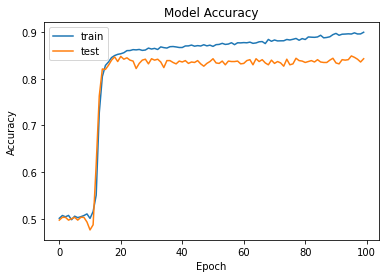

In [41]:
import matplotlib.pyplot as plt
print(history.history.keys())

#summarize for history accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train' , 'test'], loc='upper left')
plt.show()

In [42]:
model.save('Mychatbot_first.h5')

### Predicting using the model on test_data without providing answers

In [43]:
pred_res = model.predict(([input_test , query_test]))

In [44]:
print(' '.join(test_data[0][0]))
print(' '.join(test_data[0][1]))
print(''.join(test_data[0][2]))

Mary got the milk there . John moved to the bedroom .
Is John in the kitchen ?
no


In [45]:
pred_res[0]

array([1.16069165e-17, 8.48717004e-18, 1.06304852e-17, 8.70791477e-18,
       9.99995947e-01, 7.56331683e-18, 6.77854991e-18, 4.03156309e-06,
       1.02773154e-17, 6.32194373e-18, 8.62210719e-18, 8.98344284e-18,
       9.44647704e-18, 7.61929380e-18, 9.58345815e-18, 9.37961603e-18,
       9.31664029e-18, 6.60416907e-18, 8.83749013e-18, 7.96575343e-18,
       1.10406385e-17, 8.10775718e-18, 1.05982135e-17, 1.05254498e-17,
       1.08366790e-17, 8.30455586e-18, 7.66015156e-18, 9.78874205e-18,
       1.01236162e-17, 9.49666292e-18, 8.46343989e-18, 7.69092516e-18,
       8.29876063e-18, 9.11207604e-18, 1.03243101e-17, 7.60962075e-18,
       7.70075951e-18, 7.91417211e-18], dtype=float32)

In [46]:
val_max = np.argmax(pred_res[0])

In [47]:
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k=key
print("answer predicted : " , k)
print("answer probability : " , pred_res[0][val_max])

answer predicted :  no
answer probability :  0.99999595


## Writing our own stories
#### Keeping in mind of our vocab we have to see that we use words that are in our vocab

In [77]:
mystory = "John left the kitchen . Sandra dropped the football in the garden ."

In [78]:
mystory.split(' ')

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [79]:
my_ques = "Is the football in the kitchen ?"

In [80]:
my_ques.split(' ')

['Is', 'the', 'football', 'in', 'the', 'kitchen', '?']

In [81]:
my_data = [(mystory.split() , my_ques.split() , 'no')]

In [82]:
mystory , my_ques , my_ans = vectorize_stories(my_data)

In [83]:
pred_my_res = model.predict([mystory , my_ques])

In [85]:
val_max = np.argmax(pred_my_res[0])
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k=key
print("answer predicted : " , k)
print("answer probability : " , pred_my_res[0][val_max]*100 , "%")

answer predicted :  no
answer probability :  99.0454375743866 %


### That is the end.